<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


<h1>Digit Classification with Softmax</h1>


<h2>Objectives</h2>

<ul>
    <li>Download the Training and Validation MNIST Digit Images</li>
    <li>Create a Softmax Classifier using PyTorch</li>
    <li>Create a Criterion, Optimizer, and Data Loaders</li>
    <li>Create a Data Loader and set the Batch Size</li>
    <li>Train a Model</li>
    <li>Analyze Results and Model</li>
</ul> 


<h2>Table of Contents</h2>
<p>In this lab, you will use a single-layer Softmax Classifier to classify handwritten digits from the MNIST database.</p>

<ul>
    <li><a href="#Makeup_Data">Make some Data</a></li>
    <li><a href="#Classifier">Build a Softmax Classifier</a></li>
    <li><a href="#Model">Define Softmax, Criterion Function, Optimizer, and Train the Model</a></li>
    <li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>

<hr>


<h2>Preparation</h2>


We'll need the following libraries


In [2]:
!pip install torch

In [4]:
! pip install torchvision

In [5]:
# Import the libraries we need for this lab

# Using the following line code to install the torchvision library
# !conda install -y torchvision

# PyTorch Library
import torch 
# PyTorch Neural Network
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to get the digit dataset
import torchvision.datasets as dsets
# Creating graphs
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np

Use the following function to plot out the parameters of the Softmax function:


In [12]:
# The function to plot parameters

def PlotParameters(model): 
    W = model.state_dict()['linear.weight'].data
    w_min = W.min()
    w_max = W.max()
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i < 10:
            
            # Set the label for the sub-plot.
            ax.set_xlabel("class: {0}".format(i))

            # Plot the image.
            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')

            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
    plt.show()

Use the following function to visualize the data:


In [14]:
# Plot the data

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

<!--Empty Space for separating topics-->


<h2 id="Makeup_Data">Make Some Data</h2> 


Load the <em>training</em> dataset by setting the parameters <code>train</code> to <code>True</code> and convert it to a tensor by placing a transform object in the argument <code>transform</code>.


In [8]:
# Create and print the training dataset

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print("Print the training dataset:\n ", train_dataset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


C:\Users\luisr\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Load the <em>testing</em> dataset and convert it to a tensor by placing a transform object in the argument <code>transform</code>.


In [9]:
# Create and print the validation dataset

validation_dataset = dsets.MNIST(root='./data', download=True, transform=transforms.ToTensor())
print("Print the validation dataset:\n ", validation_dataset)

Print the validation dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


We can access the data by indexing the train_dataset and test_dataset


First Image and Label None


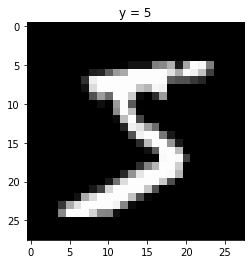

In [15]:
# Print the first image and label

print("First Image and Label", show_data(train_dataset[0]))

Each element in the rectangular tensor corresponds to a number which represents a pixel intensity, as demonstrated by the following image:


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.32_image_values.png" width="550" alt="MNIST elements" />


In this image, the values are inverted i.e black represents white.


Print out the label of the fourth element:


In [16]:
# Print the label

print("The label: ", train_dataset[3][1])

The label:  1


The result shows the number in the image is 1


Plot  the fourth sample:


The image:  None


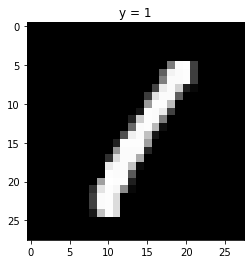

In [17]:
# Plot the image

print("The image: ", show_data(train_dataset[3]))

You see that it is a 1. Now, plot the third sample:


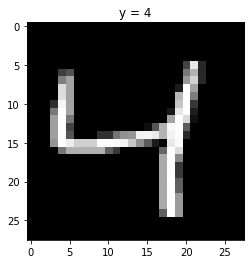

In [18]:
# Plot the image

show_data(train_dataset[2])

<!--Empty Space for separating topics-->


<h2 id="#Classifier">Build a Softmax Classifer</h2>


Build a Softmax classifier class:


In [19]:
# Define softmax classifier class
# Inherits nn.Module which is the base class for all neural networks
class SoftMax(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        # Creates a layer of given input size and output size
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        # Runs the x value through the single layers defined above
        z = self.linear(x)
        return z

The Softmax function requires vector inputs. Note that the vector shape is 28x28.


In [20]:
# Print the shape of the training dataset

train_dataset[0][0].shape

torch.Size([1, 28, 28])

Flatten the tensor as shown in this image:


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.3.2image_to_vector.gif" width="550" alt="Flattern Image" />


The size of the tensor is now 784.


<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.3.2Imagetovector2.png" width="550" alt="Flattern Image" />


Set the input size and output size:


In [21]:
# Set input size and output size

input_dim = 28 * 28
output_dim = 10

<!--Empty Space for separating topics-->


<h2 id="Model">Define the Softmax Classifier, Criterion Function, Optimizer, and Train the Model</h2> 


In [22]:
# Create the model
# Input dim is 28*28 which is the image converted to a tensor
# Output dim is 10 because there are 10 possible digits the image can be
model = SoftMax(input_dim, output_dim)
print("Print the model:\n ", model)

Print the model:
  SoftMax(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


View the size of the model parameters:


In [24]:
# Print the parameters

print('W: ',list(model.parameters())[0].size())
print('b: ',list(model.parameters())[1].size())

W:  torch.Size([10, 784])
b:  torch.Size([10])


You can convert the model parameters for each class to a rectangular grid:


<a>     <img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.3.2paramaters_to_image.gif" width = 550, align = "center"></a>


Plot the model parameters for each class as a square image:


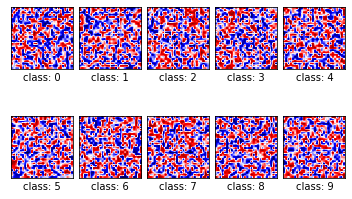

In [23]:
# Plot the model parameters for each class
# Since the model has not been trained yet the parameters look random

PlotParameters(model)

We can make a prediction


In [40]:
# First we get the X value of the first image
X = train_dataset[0][0]
# We can see the shape is 1 by 28 by 28, we need it to be flattened to 1 by 28 * 28 (784)
print(X.shape)
X = X.view(-1, 28*28)
print(X.shape)
# Now we can make a prediction, each class has a value, and the higher it is the more confident the model is that it is that digit
model(X)

torch.Size([1, 28, 28])
torch.Size([1, 784])


tensor([[-0.1092, -0.0499,  0.2917, -0.0281,  0.1151, -0.0461,  0.3556, -0.0571,
         -0.1507, -0.1991]], grad_fn=<AddmmBackward>)

Define the learning rate, optimizer, criterion, data loader:


In [64]:
# Define the learning rate, optimizer, criterion, and data loader

learning_rate = 0.1
# The optimizer will updates the model parameters using the learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# The criterion will measure the loss between the prediction and actual label values
# This is where the SoftMax occurs, it is built into the Criterion Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
# Created a training data loader so we can set the batch size
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
# Created a validation data loader so we can set the batch size
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

### How Cross Entropy Loss uses SoftMax


We have X which is the X values of the first image and `actual` which is the the digit class the image belongs to. The output `model_output` is the value the model assigns to each class for that image.


Output:  tensor([[ 0.7361, -3.5207,  0.0817,  3.8826, -5.2391,  4.8776, -0.9589,  0.5542,
          0.5099, -0.8011]], grad_fn=<AddmmBackward>)
Actual: tensor([5])


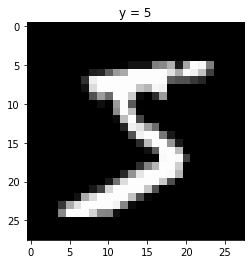

In [65]:
model_output = model(X)
actual = torch.tensor([train_dataset[0][1]])

show_data(train_dataset[0])
print("Output: ", model_output)
print("Actual:", actual)

The criterion will take these values and return a loss


In [66]:
criterion(model_output, actual)

tensor(0.3552, grad_fn=<NllLossBackward>)

Cross Entropy Loss takes probabilities and we can see that `model_output` are not probabilities, this is where softmax comes in


In [67]:
softmax = nn.Softmax(dim=1)
probability = softmax(model_output)
print(probability)

tensor([[1.1147e-02, 1.5791e-04, 5.7934e-03, 2.5920e-01, 2.8323e-05, 7.0105e-01,
         2.0463e-03, 9.2922e-03, 8.8893e-03, 2.3963e-03]],
       grad_fn=<SoftmaxBackward>)


Now that we have probabilities, we can just calculate the negative log of the probability of the class that this image belongs to. The image belongs to the target class so we calculate the negative log of the probability at the target index.


In [68]:
-1*torch.log(probability[0][actual])

tensor([0.3552], grad_fn=<MulBackward0>)

As you can see the result above matches the result of the criterion, this is how Cross Entropy Loss uses Softmax.


### Train


Train the model and determine validation accuracy **(should take a few minutes)**:


In [71]:
from IPython.display import clear_output

In [72]:
# Number of times we train our model useing the training data
n_epochs = 10
# Lists to keep track of loss and accuracy
loss_list = []
accuracy_list = []
# Size of the validation data
N_test = len(validation_dataset)

# Function to train the model based on number of epochs
def train_model(n_epochs):
    # Loops n_epochs times
    for epoch in range(n_epochs):
        clear_output(wait=True); print(f'Epoch: {epoch+1}/{n_epochs}')
        
        # For each batch in the train loader
        for x, y in train_loader:
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on the image tensor
            z = model(x.view(-1, 28 * 28))
            # Calculates loss between the model output and actual class
            loss = criterion(z, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
        
        # Each epoch we check how the model performs with data it has not seen which is the validation data, we are not training here
        correct = 0
        # For each batch in the validation loader
        for x_test, y_test in validation_loader:
            # Makes prediction based on image tensor
            z = model(x_test.view(-1, 28 * 28))
            # Finds the class with the higest output
            _, yhat = torch.max(z.data, 1)
            # Checks if the prediction matches the actual class and increments correct if it does
            correct += (yhat == y_test).sum().item()
        # Calculates the accuracy by dividing correct by size of validation dataset
        accuracy = correct / N_test
        # Keeps track loss
        loss_list.append(loss.data)
        # Keeps track of the accuracy
        accuracy_list.append(accuracy)

# Function call
train_model(n_epochs)

Epoch: 10/10


<!--Empty Space for separating topics-->


<h2 id="Result">Analyze Results</h2> 


Plot the loss and accuracy on the validation data:


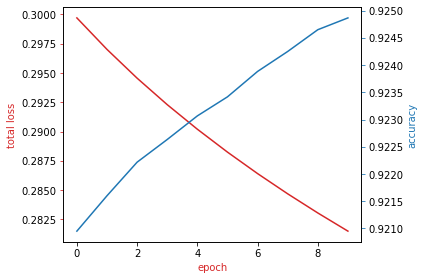

In [73]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

View the results of the parameters for each class after the training. You can see that they look like the corresponding numbers.


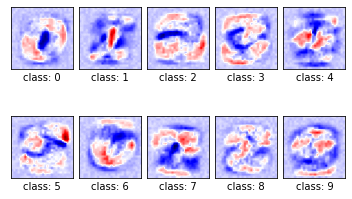

In [74]:
# Plot the parameters

PlotParameters(model)

We Plot the first five misclassified samples and the probability of that class.


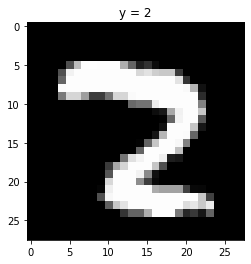

yhat: tensor([7])
probability of class  0.5400281548500061


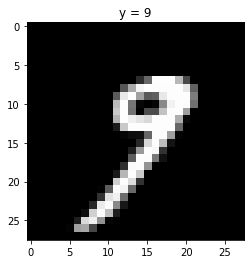

yhat: tensor([7])
probability of class  0.6776371002197266


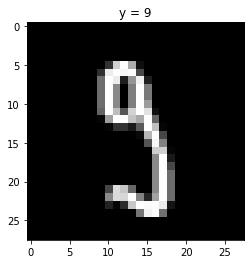

yhat: tensor([5])
probability of class  0.7503088116645813


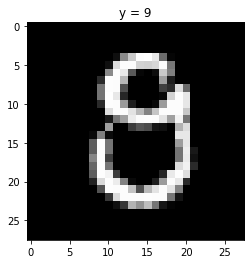

yhat: tensor([8])
probability of class  0.4441225528717041


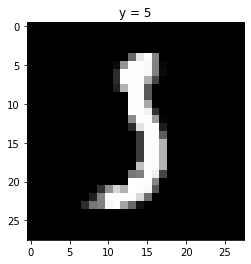

yhat: tensor([3])
probability of class  0.6473350524902344


In [75]:
# Plot the misclassified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break       

<!--Empty Space for separating topics-->


We plot the first five correctly classified samples and the probability of that class. We see the probability is much larger.


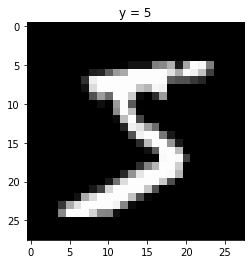

yhat: tensor([5])
probability of class  0.8590441942214966


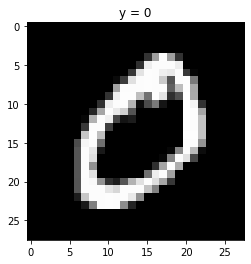

yhat: tensor([0])
probability of class  0.9998639822006226


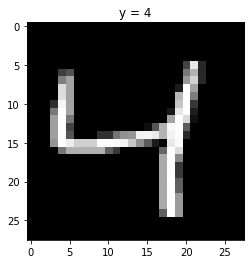

yhat: tensor([4])
probability of class  0.8640336394309998


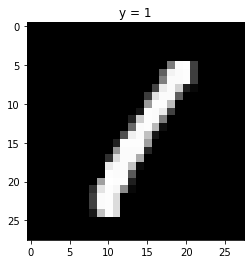

yhat: tensor([1])
probability of class  0.9643803834915161


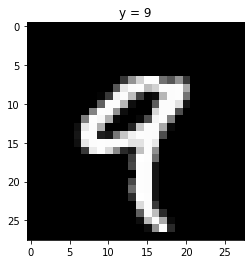

yhat: tensor([9])
probability of class  0.9361740350723267


In [76]:
# Plot the classified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat == y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break  

<a href="https://dataplatform.cloud.ibm.com/registration/stepone?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera25797139-2021-01-01&context=cpdaas&apps=data_science_experience%2Cwatson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"/></a>


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera25797139-2021-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera25797139-2021-01-01">Michelle Carey</a>, <a href="https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera25797139-2021-01-01">Mavis Zhou</a>


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description                                          |
| ----------------- | ------- | ---------- | ----------------------------------------------------------- |
| 2020-09-23        | 2.0     | Shubham    | Migrated Lab to Markdown and added to course repo in GitLab |


<hr>


## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
